In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision import transforms
from PIL import Image
import cv2
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
import os
import json
import time
import numpy as np

In [ ]:
# !unzip dataset.zip

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print('Your device - {}'.format(device))

Your device - cuda


In [3]:
train_folder = 'data/train/'
test_folder = 'data/test/'

print('Train size: {} images'.format(len(os.listdir(train_folder))))
print('Test size: {} images'.format(len(os.listdir(test_folder))))

Train size: 1134 images
Test size: 117 images


In [4]:
with open('labels/color_dict.json', 'r') as file:
    classes_color = json.load(file)

print(classes_color)

{'aqua': 0, 'black': 1, 'blue': 2, 'blue-violet': 3, 'bright-green': 4, 'bright-light-blue': 5, 'bright-light-orange': 6, 'bright-light-yellow': 7, 'bright-pink': 8, 'brown': 9, 'copper': 10, 'dark-blue-violet': 11, 'dark-bluish-gray': 12, 'dark-gray': 13, 'dark-pink': 14, 'dark-purple': 15, 'dark-tan': 16, 'dark-turquoise': 17, 'green': 18, 'lavender': 19, 'light-blue': 20, 'light-bluish-gray': 21, 'light-gray': 22, 'light-green': 23, 'light-lime': 24, 'light-nougat': 25, 'light-orange': 26, 'light-pink': 27, 'light-purple': 28, 'light-salmon': 29, 'light-turquoise': 30, 'light-violet': 31, 'light-yellow': 32, 'lime': 33, 'magenta': 34, 'medium-blue': 35, 'medium-brown': 36, 'medium-green': 37, 'medium-lavender': 38, 'medium-lime': 39, 'medium-nougat': 40, 'metal-blue': 41, 'milky-white': 42, 'nougat': 43, 'orange': 44, 'pink': 45, 'purple': 46, 'red': 47, 'reddish-brown': 48, 'salmon': 49, 'tan': 50, 'very-light-bluish-gray': 51, 'very-light-orange': 52, 'violet': 53, 'white': 54, 'y

In [5]:
with open('labels/num_class.json', 'r') as file:
    num_class = json.load(file)

print(num_class)

{'0': 'aqua', '1': 'black', '2': 'blue', '3': 'blue-violet', '4': 'bright-green', '5': 'bright-light-blue', '6': 'bright-light-orange', '7': 'bright-light-yellow', '8': 'bright-pink', '9': 'brown', '10': 'copper', '11': 'dark-blue-violet', '12': 'dark-bluish-gray', '13': 'dark-gray', '14': 'dark-pink', '15': 'dark-purple', '16': 'dark-tan', '17': 'dark-turquoise', '18': 'green', '19': 'lavender', '20': 'light-blue', '21': 'light-bluish-gray', '22': 'light-gray', '23': 'light-green', '24': 'light-lime', '25': 'light-nougat', '26': 'light-orange', '27': 'light-pink', '28': 'light-purple', '29': 'light-salmon', '30': 'light-turquoise', '31': 'light-violet', '32': 'light-yellow', '33': 'lime', '34': 'magenta', '35': 'medium-blue', '36': 'medium-brown', '37': 'medium-green', '38': 'medium-lavender', '39': 'medium-lime', '40': 'medium-nougat', '41': 'metal-blue', '42': 'milky-white', '43': 'nougat', '44': 'orange', '45': 'pink', '46': 'purple', '47': 'red', '48': 'reddish-brown', '49': 'salm

In [6]:
class LegoColorsClassification(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.data = os.listdir(self.root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.data[index])
        img = Image.open(img_path)
        label = classes_color[self.data[index].split('_')[0]]

        if self.transform:
            img = self.transform(img)

        return img, label

In [7]:
# transform = transforms.Compose([
#     transforms.PILToTensor()
# ])

# for folder in os.listdir(test_folder):
#     img = Image.open(train_folder+folder)
#     img_t = transform(img)
#     if img_t.shape[0] == 1:
#        os.remove(train_folder + folder)
#        print('Delete file')

In [8]:
train_dataset_for_viz = LegoColorsClassification(train_folder)

In [9]:
def visualization_lego(dataset, indices):
    plt.figure(figsize=(12, 9))
    num_images = len(indices)
    cols = min(num_images, 5)
    rows = num_images // cols + (num_images % cols > 0)

    for pos, index in enumerate(indices):
        plt.subplot(rows, cols, pos+1)
        img, label = dataset[index]
        plt.title(num_class[str(label)])

        try:
          plt.imshow(img)
        except:
          plt.imshow(img.permute(1, 2, 0))

        plt.axis('off')

    plt.tight_layout()
    plt.show()


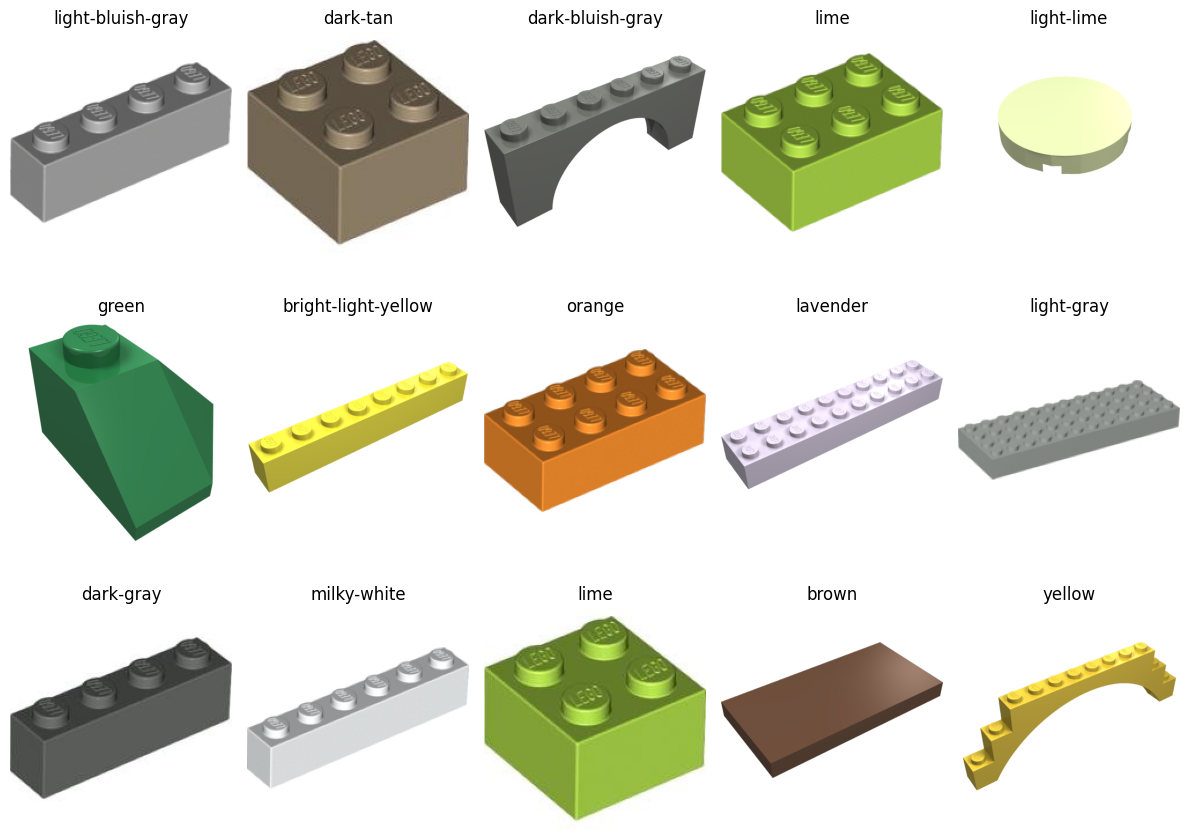

In [50]:
indices = np.random.choice(np.arange(train_dataset_for_viz.__len__()), 15)
visualization_lego(train_dataset_for_viz, indices)

In [10]:
train_dataset = LegoColorsClassification(train_folder, transform=transforms.Compose([
                                                                            transforms.Resize((128, 128)),
                                                                            transforms.RandomHorizontalFlip(p=0.5),
                                                                            transforms.RandomRotation(degrees=(-90, 90)),
                                                                            transforms.RandomVerticalFlip(p=0.5),
                                                                            transforms.ToTensor(),
                                                                            transforms.Normalize(mean=[0.8148, 0.7948, 0.7762], std=[0.2647, 0.2790, 0.3019])
]))

test_dataset = LegoColorsClassification(test_folder, transform=transforms.Compose([
                                                                            transforms.Resize((128, 128)),
                                                                            transforms.ToTensor(),
                                                                            transforms.Normalize(mean=[0.8148, 0.7948, 0.7762], std=[0.2647, 0.2790, 0.3019])
 ]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

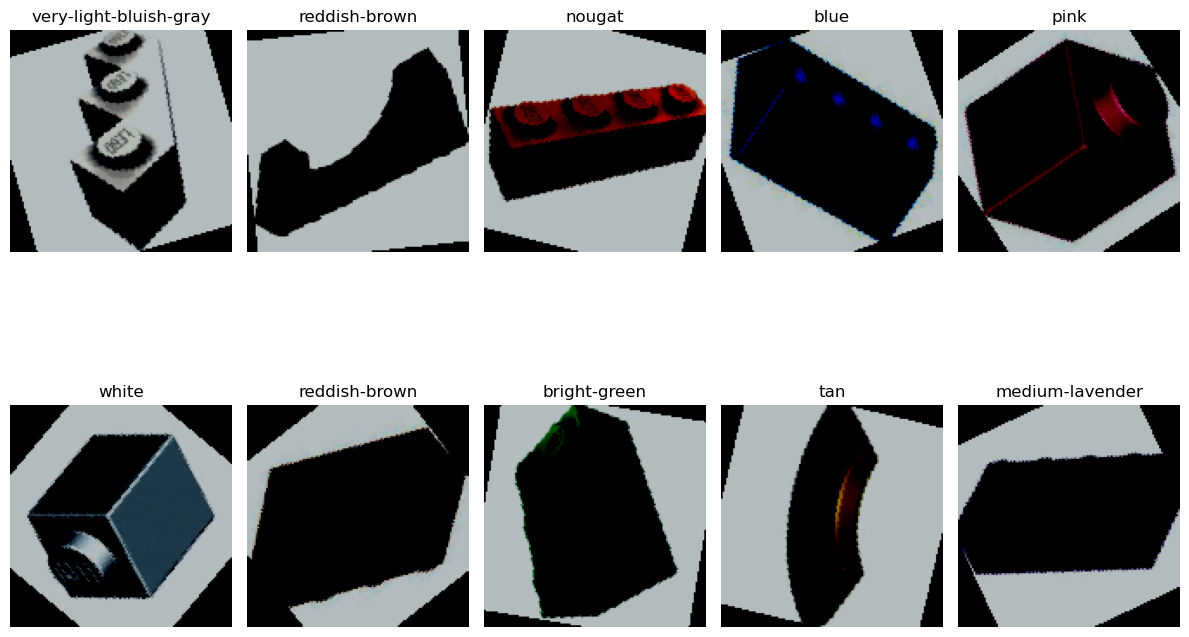

In [11]:
indices = np.random.choice(np.arange(train_dataset_for_viz.__len__()), 10)
visualization_lego(train_dataset, indices)

In [ ]:
batch_size = 32
train_dataset_length = len(train_dataset)
validation_dataset_length = int(np.floor(train_dataset_length * 0.2))

indices = list(range(train_dataset_length))
np.random.seed(42)
np.random.shuffle(indices)

train_indices, val_indices = indices[validation_dataset_length:], indices[:validation_dataset_length]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
class LegoColorNet(nn.Module):
    def __init__(self, n_chans=32):
        super(LegoColorNet, self).__init__()
        self.n_chans = n_chans
        self.conv1 = nn.Conv2d(3, n_chans, kernel_size=3, padding=1, stride=1)
        self.conv1_batch_norm = nn.BatchNorm2d(num_features=n_chans)
        self.conv2 = nn.Conv2d(n_chans, n_chans // 2, kernel_size=3, padding=1, stride=1)
        self.conv2_batch_norm = nn.BatchNorm2d(num_features=n_chans // 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(n_chans * 2 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 57)

    def forward(self, x):
        out = F.max_pool2d(F.relu(self.conv1_batch_norm(self.conv1(x))), 2)
        out = F.max_pool2d(F.relu(self.conv2_batch_norm(self.conv2(out))), 2)
        out = self.flatten(out)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [ ]:
model = LegoColorNet().to(device=device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device=device)
sheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
def training_loop(num_epochs, model, train_loader, val_loader, loss_fn, optimizer,scheduler):
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train()
        start_time = time.time()
        loss_accum = 0
        correct_samples = 0
        total_samples = 0

        for i_step, (img, labels) in enumerate(train_loader):
            img = img.to(device)
            labels = labels.to(device)

            prediction = model(img)
            loss = loss_fn(prediction, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_accum += loss.item()
            total_samples += labels.shape[0]

            _, out = torch.max(prediction, 1)
            correct_samples += torch.sum(out == labels).item()

        scheduler.step()

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)

        loss_history.append(ave_loss)
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        print('[{} | {}] Loss: {} | Train accuracy: {:3f} | Validation Accuracy: {:3f} | Time {}'.format(epoch+1, num_epochs, ave_loss, train_accuracy, val_accuracy, time.time()-start_time))

    return loss_history, train_history, val_history

def compute_accuracy(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for img, labels in val_loader:
            img = img.to(device=device)
            labels = labels.to(device=device)
            out = model(img)
            _, prediction = torch.max(out, 1)
            correct += torch.sum(prediction == labels).item()
            total += labels.shape[0]

    return correct / total


# Transfer learning

In [ ]:
# model_res = resnet50(weights=ResNet50_Weights)

In [ ]:
# num_ft = model_res.fc.in_features

# for param in model_res.parameters():
#     param.requires_grad = False

# model_res.fc = nn.Linear(num_ft, 57)
# model_res.to(device)
# optimizer = optim.Adam(model_res.fc.parameters(), lr=1e-3)
# criterion = nn.CrossEntropyLoss().to(device=device)
# sheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Обучение нейронной сети

In [ ]:
loss_history, train_history, val_history = training_loop(15, model, train_loader, val_loader, criterion, optimizer, sheduler)

[1 | 15] Loss: 3.765371995312827 | Train accuracy: 0.127753 | Validation Accuracy: 0.172566 | Time 44.49971890449524
[2 | 15] Loss: 2.6779789413724626 | Train accuracy: 0.285242 | Validation Accuracy: 0.455752 | Time 11.347832679748535
[3 | 15] Loss: 1.9327862135001592 | Train accuracy: 0.450441 | Validation Accuracy: 0.526549 | Time 11.20658564567566
[4 | 15] Loss: 1.569236010313034 | Train accuracy: 0.519824 | Validation Accuracy: 0.650442 | Time 7.75437593460083
[5 | 15] Loss: 1.358112369264875 | Train accuracy: 0.604626 | Validation Accuracy: 0.663717 | Time 8.382070064544678
[6 | 15] Loss: 1.2592312970331736 | Train accuracy: 0.648678 | Validation Accuracy: 0.668142 | Time 8.571692705154419
[7 | 15] Loss: 1.2066708441291536 | Train accuracy: 0.680617 | Validation Accuracy: 0.681416 | Time 7.714742422103882
[8 | 15] Loss: 1.2284906485251017 | Train accuracy: 0.650881 | Validation Accuracy: 0.650442 | Time 8.366394758224487
[9 | 15] Loss: 1.1782323249748774 | Train accuracy: 0.67731

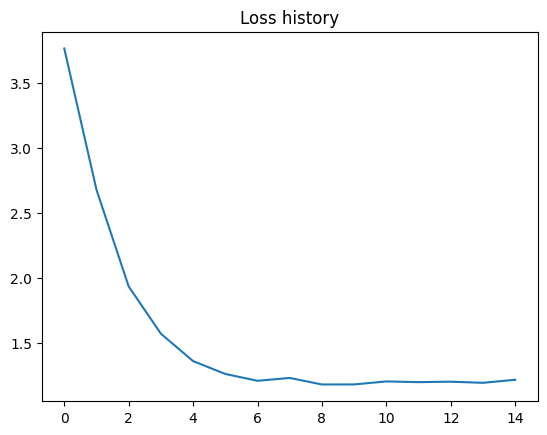

In [ ]:
plt.title('Loss history');

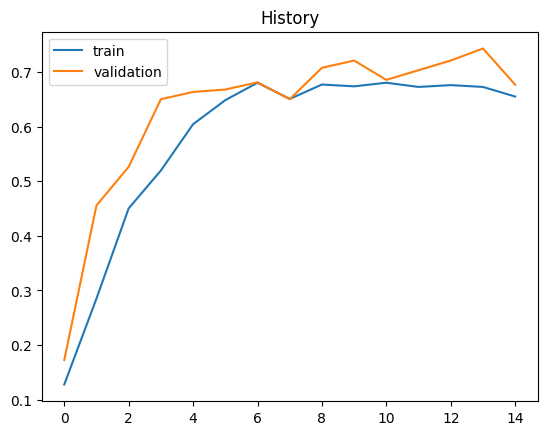

In [ ]:
plt.plot(np.arange(len(train_history)), train_history, label='train');
plt.plot(np.arange(len(val_history)), val_history, label='validation');
plt.title('History');
plt.legend()
plt.show()

In [ ]:
print('Accuracy on test: {:2f}'.format(compute_accuracy(model, test_loader)))

Accuracy on test: 0.760684


# Визуализация на тесте

In [ ]:
def visualize_model_test(model, loader, num_images=6):
    fig = plt.figure()

    reverse_normalize = transforms.Compose([
        transforms.Normalize(mean=[-0.8148/0.2647, -0.7948/0.2790, -0.7762/0.3019], std=[1/0.2647, 1/0.2790, 1/0.3019]),
    ])

    with torch.no_grad():
        images_so_far = 0
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {num_class[str(preds[j].item())]}')

                original_image = reverse_normalize(inputs.cpu().data[j])
                plt.imshow(original_image.permute(1, 2, 0))

                if images_so_far == num_images:
                    plt.tight_layout()
                    return


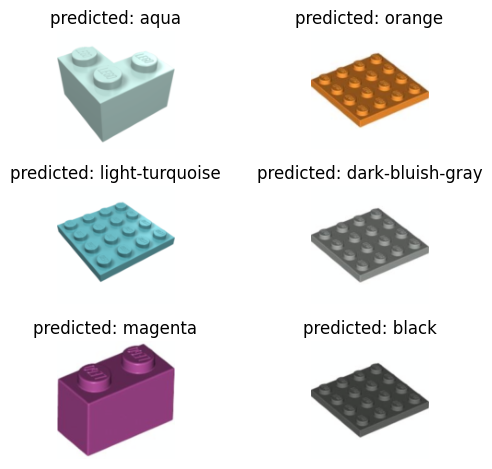

In [ ]:
visualize_model_test(model, test_loader)

# Сохранение весов модели

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')